# 0. 시작하기 앞서

책 *강화학습첫걸음*을 읽고 정리한 내용입니다. 사용된 코드는 저자의 깃허브 [저장소](https://github.com/awjuliani/DeepRL-Agents)에서 가져왔습니다.


# 1. 강화학습의 세 요소

- 액션 의존성: 각 액션은 다른 보상을 가져옵니다.
- 시간 의존성: 보상은 시간이 지연되고 나서야 주어집니다.
- 상태 의존성: 보상은 환경의 상태에 좌우됩니다.

# 밴딧 문제
강화학습에서 가장 단순한 형태의 문제

비용을 수식으로 표시하면 다음과 같습니다.

$$ Loss = - log(\pi)*A $$
여기서 A는 **Advantage**로서 강화학습 알고리즘의 필수요소 입니다.

# 마르코프 결정 과정(MDP)
마르코프 결정과정(Markov Decision process)는 에이전트에게 완전한 문제를 제시하는 환경입니다. 어떤 과제든 MDP로 표현할 수 있습니다. 예를 들어 문을 여는 것을 상상해 봅니다. 이때의 상태는 우리의 몸의 위치와 문의 위치등이 될 수 있습니다. 행동은 우리의 몸이 만들어내는 모든 동작이 됩니다. 보상은 열린 문이 되겠습니다.

In [61]:
# 필요한 라이브러리를 불러옵니다.
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import gym
import matplotlib.pyplot as plt
%matplotlib inline

print("사용한 Numpy 버전 {}, Tensorflow 버전은 {} 입니다.".format(np.version.version , tf.__version__))

사용한 Numpy 버전 1.12.1, Tensorflow 버전은 1.3.0 입니다.


## 4.1 기본적인 구현


In [62]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


The Policy-Based Agent

In [63]:
gamma = 0.99

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        hidden = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,a_size,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

Training the Agent

In [64]:
tf.reset_default_graph() #Clear the Tensorflow graph.

myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8) #Load the agent.

total_episodes = 5000 #Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            #Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if d == True:
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
            #Update our running tally of scores.
        if i % 1000 == 0:
            print(np.mean(total_reward[-100:]))
        i += 1

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


21.0
183.34
185.01
180.63
197.15


점점 시간이 늘어난 것을 확인 할 수 있습니다. 

# Q 러닝

Q러닝은 각 상태 내에서의 값을 학습하고자 시도하며 그 상태 내에서 특정 액션을 취합니다.


In [9]:
# Load the environment
env = gym.make('FrozenLake-v0')
# Implement Q-Table learning algorithm
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

print("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 0.4145


In [10]:
print("Final Q-Table Values")
print(Q)

Final Q-Table Values
[[  4.21287833e-03   3.99651302e-03   1.64633532e-01   4.82147285e-03]
 [  2.37113659e-04   2.67972702e-04   5.57433680e-04   1.07443128e-01]
 [  1.07484057e-03   1.06982180e-03   3.51812188e-03   6.63885614e-02]
 [  9.14643248e-04   6.06924071e-06   6.65783676e-04   3.49788604e-02]
 [  4.64545307e-01   2.53794239e-04   2.33741614e-04   9.58178853e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.50428058e-02   9.75678622e-05   1.27225381e-04   4.50827000e-06]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.20636724e-04   2.87574983e-04   3.24477041e-04   5.14538313e-01]
 [  3.00442944e-04   6.67222669e-01   1.25428587e-04   1.42980135e-03]
 [  9.06457381e-01   1.01954600e-03   7.75018879e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.51104505e-03   6.59155290e-01   0

## Q 네트워크 구현


In [11]:
env = gym.make('FrozenLake-v0')
tf.reset_default_graph()
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

# Training the network
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.124%



Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.



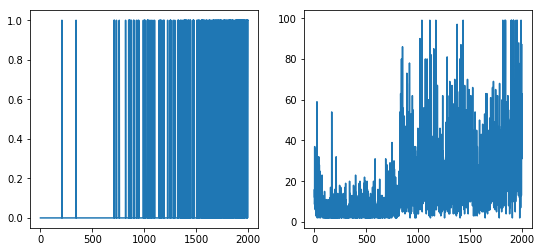

In [17]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(9, 4))
ax0.plot(rList)
ax1.plot(jList)


# 딥 Q 네트워크(DQN)
앞서 살펴본 Q 네트워크는 성능이 좋지 않지만, 딥 Q 네트워크는 훨씬 더 강력한 성능을 보여줍니다.
Q 네트워크를 DQN으로 만들기 위해서는 다음과 같은 개선이 필요합니다.
1. 단일 계층 네트워크를 다층 합성곱으로 확장
2. 경험 리플레이의 구현
3. 제2의 타깃 네트워크를 활용해 업데이트시 타깃 Q값을 계산

> DQN은 빠르게 발전하고 있어 다양한 기법들이 나오고 있습니다.

DQN에서도 널리 알려진 더블 DQN과 듀얼 DQN을 살펴보겠습니다.

## DDQN

In [53]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### 게임 환경 로딩
환경을 로딩하고 그리드의 크기를 설정합니다.

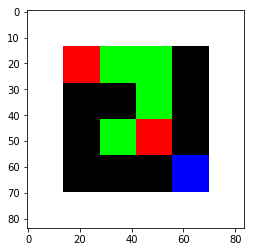

In [54]:
# gridworld.py 파일을 불러옵니다.
from gridworld import gameEnv

env = gameEnv(partial=False,size=4)

위 그림은 게임 시작화면의 예시입니다. 에이전트는 파란색 블럭을 이동시켜 녹색블럭은 **+1**, 빨간블럭은 **-1**의 보상을 줍니다. 블럭의 위치는 매번 랜덤하게 변합니다.

### 네트워크 만들기

네트워크를 클래스로 구현하는 부분입니다.

In [55]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID',
                                 biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID',
                                 biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID',
                                 biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID',
                                 biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,
                                                                           axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

### 경험 리플레이
경험과 샘플을 저장하고 네트워크를 학습시키는 클래스를 정의합니다.

In [56]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

게임 프레임의 크기와 네트워크의 매개 변수를 업데이트하는 기능을 만듭니다.

In [57]:
def processState(states):
    return np.reshape(states,[21168])

def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) +
                                                          ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

### 네트워크 학습하기
아래와 같이 학습 매개변수를 설정합니다.

In [58]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 1000. #How many steps of training to reduce startE to endE.
num_episodes = 2000 #How many episodes of game environment to train network with.
pre_train_steps = 1000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

텐서플로로 학습을 시킵니다.
> 시간이 오래걸리니 주의하세요

In [59]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 200 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
10000 5.3 0.09999999999998849
20000 11.0 0.09999999999998849
30000 25.3 0.09999999999998849
40000 27.3 0.09999999999998849
50000 28.9 0.09999999999998849
Saved Model
60000 30.3 0.09999999999998849
70000 27.6 0.09999999999998849
80000 31.4 0.09999999999998849
90000 29.8 0.09999999999998849
100000 29.2 0.09999999999998849
Percent of succesful episodes: 23.241%


### 시각화
학습과정을 시각화 하면 다음과 같습니다.

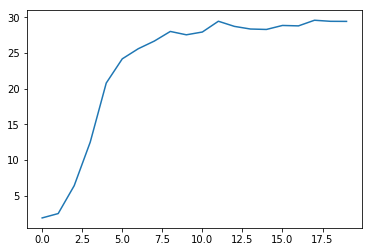

In [60]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)



# 7. 부분관찰성과 순환 신경망


# 8. 비동기적 어드밴티지 액터-크리틱(A3C)
비동기적 어드밴티지 액터-크리틱(Asynchonous Advantage Actor-Critic) 알고리즘을 텐서플로에서 구현해보겠습니다. A3C는 이전 방식(DQN)보다 빠르고 강건하게 학습을 할 수 있습니다. 따라서 복잡한 상태와 액션 공간을 가지는 문제들을 해결하는 데 필수적인 알고리즘이 되었습니다. 

## 8.2 A3C 구현
1. 에이전트가 전역 네트워크로 초기화합니다.
2. 에이전트가 환경과 상호작용합니다.
3. 에이전트가 가치와 정책비용을 계산합니다.
4. 에이전트가 비용으로부터 경사를 구합니다.
5. 에이전트가 경사를 이용해 전역 네트워크를 업데이트합니다.
6. 1로 돌아갑니다.


In [65]:
import threading
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy.signal
%matplotlib inline
from helper import *
from vizdoom import *

from random import choice
from time import sleep
from time import time

ModuleNotFoundError: No module named 'helper'

# Helper Functions

In [66]:
# Copies one set of variables to another.
# Used to set worker network parameters to those of global network.
def update_target_graph(from_scope,to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

# Processes Doom screen image to produce cropped and resized image. 
def process_frame(frame):
    s = frame[10:-10,30:-30]
    s = scipy.misc.imresize(s,[84,84])
    s = np.reshape(s,[np.prod(s.shape)]) / 255.0
    return s

# Discounting function used to calculate discounted returns.
def discount(x, gamma):
    return scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

#Used to initialize weights for policy and value output layers
def normalized_columns_initializer(std=1.0):
    def _initializer(shape, dtype=None, partition_info=None):
        out = np.random.randn(*shape).astype(np.float32)
        out *= std / np.sqrt(np.square(out).sum(axis=0, keepdims=True))
        return tf.constant(out)
    return _initializer

# Actor-Critic Network

In [67]:
class AC_Network():
    def __init__(self,s_size,a_size,scope,trainer):
        with tf.variable_scope(scope):
            #Input and visual encoding layers
            self.inputs = tf.placeholder(shape=[None,s_size],dtype=tf.float32)
            self.imageIn = tf.reshape(self.inputs,shape=[-1,84,84,1])
            self.conv1 = slim.conv2d(activation_fn=tf.nn.elu,
                inputs=self.imageIn,num_outputs=16,
                kernel_size=[8,8],stride=[4,4],padding='VALID')
            self.conv2 = slim.conv2d(activation_fn=tf.nn.elu,
                inputs=self.conv1,num_outputs=32,
                kernel_size=[4,4],stride=[2,2],padding='VALID')
            hidden = slim.fully_connected(slim.flatten(self.conv2),256,activation_fn=tf.nn.elu)
            
            #Recurrent network for temporal dependencies
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(256,state_is_tuple=True)
            c_init = np.zeros((1, lstm_cell.state_size.c), np.float32)
            h_init = np.zeros((1, lstm_cell.state_size.h), np.float32)
            self.state_init = [c_init, h_init]
            c_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.c])
            h_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.h])
            self.state_in = (c_in, h_in)
            rnn_in = tf.expand_dims(hidden, [0])
            step_size = tf.shape(self.imageIn)[:1]
            state_in = tf.contrib.rnn.LSTMStateTuple(c_in, h_in)
            lstm_outputs, lstm_state = tf.nn.dynamic_rnn(
                lstm_cell, rnn_in, initial_state=state_in, sequence_length=step_size,
                time_major=False)
            lstm_c, lstm_h = lstm_state
            self.state_out = (lstm_c[:1, :], lstm_h[:1, :])
            rnn_out = tf.reshape(lstm_outputs, [-1, 256])
            
            #Output layers for policy and value estimations
            self.policy = slim.fully_connected(rnn_out,a_size,
                activation_fn=tf.nn.softmax,
                weights_initializer=normalized_columns_initializer(0.01),
                biases_initializer=None)
            self.value = slim.fully_connected(rnn_out,1,
                activation_fn=None,
                weights_initializer=normalized_columns_initializer(1.0),
                biases_initializer=None)
            
            #Only the worker network need ops for loss functions and gradient updating.
            if scope != 'global':
                self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
                self.actions_onehot = tf.one_hot(self.actions,a_size,dtype=tf.float32)
                self.target_v = tf.placeholder(shape=[None],dtype=tf.float32)
                self.advantages = tf.placeholder(shape=[None],dtype=tf.float32)

                self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])

                #Loss functions
                self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_v - tf.reshape(self.value,[-1])))
                self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy))
                self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs)*self.advantages)
                self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy * 0.01

                #Get gradients from local network using local losses
                local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
                self.gradients = tf.gradients(self.loss,local_vars)
                self.var_norms = tf.global_norm(local_vars)
                grads,self.grad_norms = tf.clip_by_global_norm(self.gradients,40.0)
                
                #Apply local gradients to global network
                global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

# Worker Agent

In [ ]:
class Worker():
    def __init__(self,game,name,s_size,a_size,trainer,model_path,global_episodes):
        self.name = "worker_" + str(name)
        self.number = name        
        self.model_path = model_path
        self.trainer = trainer
        self.global_episodes = global_episodes
        self.increment = self.global_episodes.assign_add(1)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_mean_values = []
        self.summary_writer = tf.summary.FileWriter("train_"+str(self.number))

        #Create the local copy of the network and the tensorflow op to copy global paramters to local network
        self.local_AC = AC_Network(s_size,a_size,self.name,trainer)
        self.update_local_ops = update_target_graph('global',self.name)        
        
        #The Below code is related to setting up the Doom environment
        game.set_doom_scenario_path("basic.wad") #This corresponds to the simple task we will pose our agent
        game.set_doom_map("map01")
        game.set_screen_resolution(ScreenResolution.RES_160X120)
        game.set_screen_format(ScreenFormat.GRAY8)
        game.set_render_hud(False)
        game.set_render_crosshair(False)
        game.set_render_weapon(True)
        game.set_render_decals(False)
        game.set_render_particles(False)
        game.add_available_button(Button.MOVE_LEFT)
        game.add_available_button(Button.MOVE_RIGHT)
        game.add_available_button(Button.ATTACK)
        game.add_available_game_variable(GameVariable.AMMO2)
        game.add_available_game_variable(GameVariable.POSITION_X)
        game.add_available_game_variable(GameVariable.POSITION_Y)
        game.set_episode_timeout(300)
        game.set_episode_start_time(10)
        game.set_window_visible(False)
        game.set_sound_enabled(False)
        game.set_living_reward(-1)
        game.set_mode(Mode.PLAYER)
        game.init()
        self.actions = self.actions = np.identity(a_size,dtype=bool).tolist()
        #End Doom set-up
        self.env = game
        
    def train(self,rollout,sess,gamma,bootstrap_value):
        rollout = np.array(rollout)
        observations = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        next_observations = rollout[:,3]
        values = rollout[:,5]
        
        # Here we take the rewards and values from the rollout, and use them to 
        # generate the advantage and discounted returns. 
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        feed_dict = {self.local_AC.target_v:discounted_rewards,
            self.local_AC.inputs:np.vstack(observations),
            self.local_AC.actions:actions,
            self.local_AC.advantages:advantages,
            self.local_AC.state_in[0]:self.batch_rnn_state[0],
            self.local_AC.state_in[1]:self.batch_rnn_state[1]}
        v_l,p_l,e_l,g_n,v_n, self.batch_rnn_state,_ = sess.run([self.local_AC.value_loss,
            self.local_AC.policy_loss,
            self.local_AC.entropy,
            self.local_AC.grad_norms,
            self.local_AC.var_norms,
            self.local_AC.state_out,
            self.local_AC.apply_grads],
            feed_dict=feed_dict)
        return v_l / len(rollout),p_l / len(rollout),e_l / len(rollout), g_n,v_n
        
    def work(self,max_episode_length,gamma,sess,coord,saver):
        episode_count = sess.run(self.global_episodes)
        total_steps = 0
        print ("Starting worker " + str(self.number))
        with sess.as_default(), sess.graph.as_default():                 
            while not coord.should_stop():
                sess.run(self.update_local_ops)
                episode_buffer = []
                episode_values = []
                episode_frames = []
                episode_reward = 0
                episode_step_count = 0
                d = False
                
                self.env.new_episode()
                s = self.env.get_state().screen_buffer
                episode_frames.append(s)
                s = process_frame(s)
                rnn_state = self.local_AC.state_init
                self.batch_rnn_state = rnn_state
                while self.env.is_episode_finished() == False:
                    #Take an action using probabilities from policy network output.
                    a_dist,v,rnn_state = sess.run([self.local_AC.policy,self.local_AC.value,self.local_AC.state_out], 
                        feed_dict={self.local_AC.inputs:[s],
                        self.local_AC.state_in[0]:rnn_state[0],
                        self.local_AC.state_in[1]:rnn_state[1]})
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)

                    r = self.env.make_action(self.actions[a]) / 100.0
                    d = self.env.is_episode_finished()
                    if d == False:
                        s1 = self.env.get_state().screen_buffer
                        episode_frames.append(s1)
                        s1 = process_frame(s1)
                    else:
                        s1 = s
                        
                    episode_buffer.append([s,a,r,s1,d,v[0,0]])
                    episode_values.append(v[0,0])

                    episode_reward += r
                    s = s1                    
                    total_steps += 1
                    episode_step_count += 1
                    
                    # If the episode hasn't ended, but the experience buffer is full, then we
                    # make an update step using that experience rollout.
                    if len(episode_buffer) == 30 and d != True and episode_step_count != max_episode_length - 1:
                        # Since we don't know what the true final return is, we "bootstrap" from our current
                        # value estimation.
                        v1 = sess.run(self.local_AC.value, 
                            feed_dict={self.local_AC.inputs:[s],
                            self.local_AC.state_in[0]:rnn_state[0],
                            self.local_AC.state_in[1]:rnn_state[1]})[0,0]
                        v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,v1)
                        episode_buffer = []
                        sess.run(self.update_local_ops)
                    if d == True:
                        break
                                            
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_step_count)
                self.episode_mean_values.append(np.mean(episode_values))
                
                # Update the network using the episode buffer at the end of the episode.
                if len(episode_buffer) != 0:
                    v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,0.0)
                                
                    
                # Periodically save gifs of episodes, model parameters, and summary statistics.
                if episode_count % 5 == 0 and episode_count != 0:
                    if self.name == 'worker_0' and episode_count % 25 == 0:
                        time_per_step = 0.05
                        images = np.array(episode_frames)
                        make_gif(images,'./frames/image'+str(episode_count)+'.gif',
                            duration=len(images)*time_per_step,true_image=True,salience=False)
                    if episode_count % 250 == 0 and self.name == 'worker_0':
                        saver.save(sess,self.model_path+'/model-'+str(episode_count)+'.cptk')
                        print ("Saved Model")

                    mean_reward = np.mean(self.episode_rewards[-5:])
                    mean_length = np.mean(self.episode_lengths[-5:])
                    mean_value = np.mean(self.episode_mean_values[-5:])
                    summary = tf.Summary()
                    summary.value.add(tag='Perf/Reward', simple_value=float(mean_reward))
                    summary.value.add(tag='Perf/Length', simple_value=float(mean_length))
                    summary.value.add(tag='Perf/Value', simple_value=float(mean_value))
                    summary.value.add(tag='Losses/Value Loss', simple_value=float(v_l))
                    summary.value.add(tag='Losses/Policy Loss', simple_value=float(p_l))
                    summary.value.add(tag='Losses/Entropy', simple_value=float(e_l))
                    summary.value.add(tag='Losses/Grad Norm', simple_value=float(g_n))
                    summary.value.add(tag='Losses/Var Norm', simple_value=float(v_n))
                    self.summary_writer.add_summary(summary, episode_count)

                    self.summary_writer.flush()
                if self.name == 'worker_0':
                    sess.run(self.increment)
                episode_count += 1

## set a parameter

In [ ]:
max_episode_length = 300
gamma = .99 # discount rate for advantage estimation and reward discounting
s_size = 7056 # Observations are greyscale frames of 84 * 84 * 1
a_size = 3 # Agent can move Left, Right, or Fire
load_model = False
model_path = './model'

In [ ]:


tf.reset_default_graph()

if not os.path.exists(model_path):
    os.makedirs(model_path)
    
#Create a directory to save episode playback gifs to
if not os.path.exists('./frames'):
    os.makedirs('./frames')

with tf.device("/cpu:0"): 
    global_episodes = tf.Variable(0,dtype=tf.int32,name='global_episodes',trainable=False)
    trainer = tf.train.AdamOptimizer(learning_rate=1e-4)
    master_network = AC_Network(s_size,a_size,'global',None) # Generate global network
    num_workers = multiprocessing.cpu_count() # Set workers to number of available CPU threads
    workers = []
    # Create worker classes
    for i in range(num_workers):
        workers.append(Worker(DoomGame(),i,s_size,a_size,trainer,model_path,global_episodes))
    saver = tf.train.Saver(max_to_keep=5)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
        
    # This is where the asynchronous magic happens.
    # Start the "work" process for each worker in a separate threat.
    worker_threads = []
    for worker in workers:
        worker_work = lambda: worker.work(max_episode_length,gamma,sess,coord,saver)
        t = threading.Thread(target=(worker_work))
        t.start()
        sleep(0.5)
        worker_threads.append(t)
    coord.join(worker_threads)